# IMDb Dataset Analysis

Dataset source: [IMDb](https://www.imdb.com/interfaces/) 

**IMDb Dataset Details**: 
1. There are 7 datasets in total. Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. 
2. The first line in each file contains headers that describe what is in each column.
3. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. 
4. The dataset was downloaded on `March 6, 2023`. The data is refreshed daily.
5. Thesee dataset share the same column `tconst (string)` which is an alphanumeric unique identifier of the title.

### <span style="color:green">**Objective: Predict the average ratings for `movies` based on given features.**</span> 

This notebook will do the IMDb dataset analysis following the next steps. Corresponding reasoning and analysis are also provided. 
1. Exploratory Data Analysis (EDA) and Data Cleaning.
2. Data Preprocessing.
3. ML Model Training.
4. Conclusions.
5. Future Directions.


## <span style="color:blue">Step 1: Exploratory Data Analysis (EDA) and Data Cleaning</span>

In this section, we will import the required libraries and load the datasets into Python environment. Then, we will take a look at each dataset and perform some exploratory analysis and data cleaning tasks. 

In [2]:
import pandas as pd
import numpy as np

# For plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

style.use('seaborn-poster')
sns.set_style('darkgrid')

# For data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

We will define a function to load data into Python environment as Pandas DataFrames in order to avoid repetitive work. 

In [3]:
def read_csv_file(file_name: str, dtype: dict, usecols: list):
    return pd.read_csv(file_name, sep='\t', index_col=False, na_values='\\N', dtype=dtype, usecols=usecols)
# index_col=False: force pandas to not use the first colum as the index

### <span style="color:maroon">title.akas.tsv.gz</span> 
Contains the following information for titles:

`titleId` (string) - a tconst, an alphanumeric unique identifier of the title <br>
`ordering` (integer) – a number to uniquely identify rows for a given titleId <br>
`title` (string) – the localized title <br>
`region` (string) - the region for this version of the title <br>
`language` (string) - the language of the title <br>
`types` (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning <br>
`attributes` (array) - Additional terms to describe this alternative title, not enumerated <br>
`isOriginalTitle` (boolean) – 0: not original title; 1: original title <br>

Among all the given features, only `titleId`, `ordering`, `title`, `region`, `language`, `types` are highly related to the average ratings of movies. So we will only read these columns.

In [4]:
df_akas_dtypes = {'titleId': 'str', 'ordering': 'int', 'region': 'str', 'language': 'str', 'types': 'str'}
df_akas_usecols = ['titleId', 'ordering', 'region', 'language', 'types']

df_akas = read_csv_file('./datasets/title.akas.tsv', df_akas_dtypes, df_akas_usecols)

In [5]:
df_akas.head()

,titleId,ordering,region,language,types
0,tt0000001,1,UA,NaN,imdbDisplay
1,tt0000001,2,DE,NaN,NaN
2,tt0000001,3,HU,NaN,imdbDisplay
3,tt0000001,4,GR,NaN,imdbDisplay
4,tt0000001,5,RU,NaN,imdbDisplay


In [6]:
df_akas.tail()

,titleId,ordering,region,language,types
35165554,tt9916852,5,PT,pt,NaN
35165555,tt9916852,6,IT,it,NaN
35165556,tt9916852,7,IN,hi,NaN
35165557,tt9916856,1,DE,NaN,imdbDisplay
35165558,tt9916856,2,NaN,NaN,original


Take a look at the `types` column and count the frequency for each type.

In [7]:
df_akas['types'].value_counts()

imdbDisplay             3440324
original                1806783
alternative              108716
working                   53470
dvd                       21893
video                     20689
festival                  19007
tv                        18469
dvdimdbDisplay             233
imdbDisplaytv               74
festivalimdbDisplay         66
imdbDisplayworking          31
imdbDisplayvideo            26
alternativetv                9
tvvideo                      7
alternativedvd               6
videoworking                 5
alternativeworking           5
tvworking                    4
festivalworking              3
alternativevideo             2
dvdvideo                     2
alternativefestival          2
Name: types, dtype: int64

`imdbDisplay` has the maximum frequency of `3440324` followed by `original`, `alternative` and so on.

Based on the `language` column, we can figure out the most popular language among all movies/TV shows. Since there are many languages, let's show only the top 15 languages.

In [8]:
df_akas_lang = df_akas.groupby('language').size().sort_values(ascending=False).reset_index(name='frequency')
df_akas_lang.head(15)

,language,frequency
0,ja,4068637
1,fr,4033790
2,hi,4007162
3,es,3977420
4,de,3976847
5,it,3975479
6,pt,3975333
7,en,446828
8,tr,35150
9,ru,34145


It shows that `ja` (Japanese) is the most popular language followed by `fr` (French), `hi` (Hindi), `es` (Espaniol) and so on. 

The number of languages a movie/TV show was out plays a role in IMDb ratings since the more number of languages a movie/TV show has, the more number of viewers, and thus more viewers would rate the movie/TV show, which influences its average rating. <br>
Following this line of thought, we can generate a new column `num_of_lang` to represent the number of languages a movie/TV show has. 

In [9]:
df_akas.head(20)

,titleId,ordering,region,language,types
0,tt0000001,1,UA,NaN,imdbDisplay
1,tt0000001,2,DE,NaN,NaN
2,tt0000001,3,HU,NaN,imdbDisplay
3,tt0000001,4,GR,NaN,imdbDisplay
4,tt0000001,5,RU,NaN,imdbDisplay
5,tt0000001,6,US,NaN,imdbDisplay
6,tt0000001,7,NaN,NaN,original
7,tt0000001,8,JP,ja,imdbDisplay
8,tt0000002,1,NaN,NaN,original
9,tt0000002,2,FR,NaN,imdbDisplay


Note that for each unique `titleId`, there are duplicate rows and each row represents a region and thus a corresponding language. <br>
Based on this info, we can get the number of languages for each movie/TV show and drop unrelevant columns (`region`, `language`, `types`).

In [10]:
df_akas.drop(labels=['region', 'language', 'types'], axis=1, inplace=True)

In [11]:
df_akas.head()

,titleId,ordering
0,tt0000001,1
1,tt0000001,2
2,tt0000001,3
3,tt0000001,4
4,tt0000001,5


In [12]:
df_akas.rename(columns={'ordering': 'num_of_lang'}, inplace=True) # change the column name
df_akas.head()

,titleId,num_of_lang
0,tt0000001,1
1,tt0000001,2
2,tt0000001,3
3,tt0000001,4
4,tt0000001,5


In [13]:
# get rid of duplicates
df_akas_final = df_akas.drop_duplicates(subset='titleId', keep='last')
df_akas_final.head()

,titleId,num_of_lang
7,tt0000001,8
15,tt0000002,8
24,tt0000003,9
32,tt0000004,8
44,tt0000005,9


In [14]:
print(f'The shape of original dataframe (df_akas) is {df_akas.shape}') 
print(f'The shape of the final dataframe (df_akas_final) is {df_akas_final.shape}')

The shape of original dataframe (df_akas) is (35165559, 2)
The shape of the final dataframe (df_akas_final) is (6925445, 2)


Note that we reduce the dataframe size significantly by doing feature selection: dropping certain columns and creating a new feature column `num_of_lang`.

Next, let's figure out what is **the most common number of languages** for a movie/TV show was produced in.

In [15]:
df_akas_final['num_of_lang'].value_counts()

7     3998607
2     1234008
1     1144187
3      255230
9       97093
4       81560
5       62447
6       35846
8       16466
99          1
Name: num_of_lang, dtype: int64

In [16]:
df_akas_final.describe()

,num_of_lang
count,6.925445e+06
mean,4.942261e+00
std,2.639061e+00
min,1.000000e+00
25%,2.000000e+00
50%,7.000000e+00
75%,7.000000e+00
max,9.900000e+01


### <span style="color:green">**Insights:**</span>
1. Most movies/TV shows were produced in `7` languages, followed by `2` and `1` languages.
2. The mean number of languages for a movie/TV show was produced is `4.94` (5 approximate).

Since we are given multiple datasets for this project, let's look at them one by one to see what insights do they add to our understanding of the problem.

Next, we will take a look at the `title.ratings.tsv` dataset, which contains the **Dependent Variable (averageRating)** for our ML model. 

### <span style="color:maroon">title.ratings.tsv</span>
– Contains the IMDb rating and votes information for titles

`tconst` (string) - alphanumeric unique identifier of the title <br>
`averageRating` – weighted average of all the individual user ratings <br>
`numVotes` - number of votes the title has received

We load all the columns since they are all important for the prediction goal. 

In [17]:
df_ratings_dtype = {'tconst': 'str', 'averageRating': 'float', 'numVotes': 'int'}
df_ratings_usecols = ['tconst', 'averageRating', 'numVotes']

df_ratings = read_csv_file('./datasets/title.ratings.tsv', df_ratings_dtype, df_ratings_usecols)

In [18]:
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1958
1,tt0000002,5.8,263
2,tt0000003,6.5,1791
3,tt0000004,5.6,179
4,tt0000005,6.2,2594


In [19]:
df_ratings.tail()

,tconst,averageRating,numVotes
1286104,tt9916730,8.3,10
1286105,tt9916766,7.0,21
1286106,tt9916778,7.2,36
1286107,tt9916840,8.8,6
1286108,tt9916880,8.2,6


In [20]:
df_ratings.shape

(1286109, 3)

In [21]:
df_ratings.isnull().value_counts()

tconst  averageRating  numVotes
False   False          False       1286109
dtype: int64

There are no `NaN` values in this dataset.

In [22]:
len(df_ratings['tconst'].unique())

1286109

Since there are `1286109` rows in this dataset and the number of unique values in the column `tconst` is `1286109`, there are no duplicates of `tconst` in this datset.

Let's plot a histogram to show the averageRating distribution.

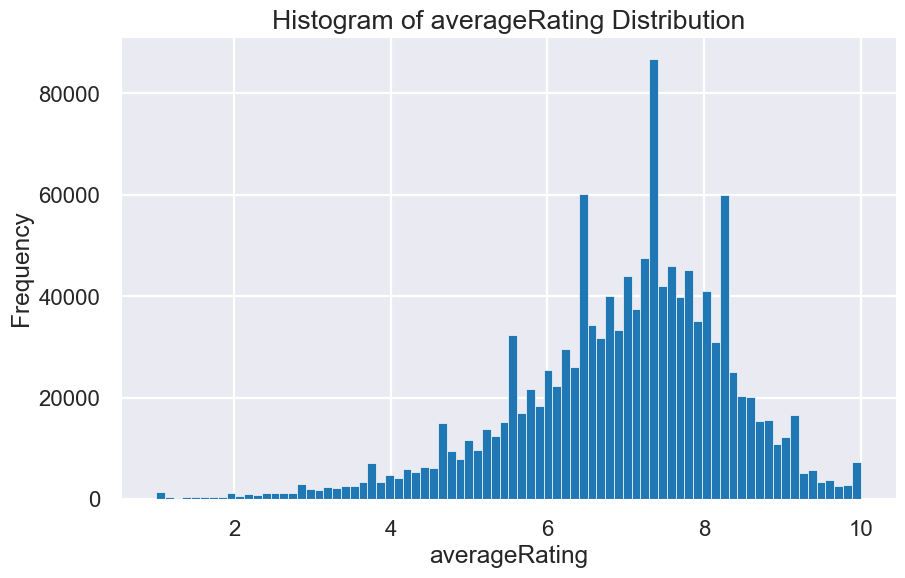

In [23]:
plt.figure(figsize=(10,6))
plt.hist(df_ratings['averageRating'], bins=80)
plt.grid('ON')
plt.xlabel('averageRating')
plt.ylabel('Frequency')
plt.title('Histogram of averageRating Distribution');

Since the `averageRating` and `numVotes` columns are numerical values, we can calculate the summary statistics.

In [24]:
df_ratings.describe()

,averageRating,numVotes
count,1.286109e+06,1.286109e+06
mean,6.949707e+00,1.041075e+03
std,1.385453e+00,1.739146e+04
min,1.000000e+00,5.000000e+00
25%,6.200000e+00,1.100000e+01
50%,7.100000e+00,2.600000e+01
75%,7.900000e+00,1.010000e+02
max,1.000000e+01,2.709711e+06


### <span style="color:green">**Insights:**</span>
1. The dependent variable `averageRating` is a continuous numerical variable with a mean of `6.95` and standard deviation of `1.39`. The IMDb rating varies from a minimum of `1.0` to a maximum of `10.0`.
2. `numVotes` is a continuous numerical variable with a mean of `1041.1` and standard deviation of `17391.5`. The number of votes varies from a minimum of `5` to a maximum of `2709711`. This indicates that the `numVotes` column has pretty spreadout values with a huge standard deviation and thus is likely to contain outliers.

Next, we will take a look at `title.basics.tsv` dataset.

### <span style="color:maroon">title.basics.tsv</span>
- Contains the following information for titles:

`tconst` (string) - alphanumeric unique identifier of the title <br>
`titleType` (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc) <br>
`primaryTitle` (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release <br>
`originalTitle` (string) - original title, in the original language <br>
`isAdult` (boolean) - 0: non-adult title; 1: adult title <br>
`startYear` (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year <br>
`endYear` (YYYY) – TV Series end year. ‘\N’ for all other title types <br>
`runtimeMinutes` – primary runtime of the title, in minutes <br>
`genres` (string array) – includes up to three genres associated with the title <br>

Among all the feature columns in this dataset, we think the column `tconst`, `isAdult`, `startYear`, `endYear`, `runtimeMinutes`, `genres` play a key role in the IMDb ratings. Thus we drop all the other columns.

#### <span style="color:blue">**Things of interest:**</span>
1. Since the objective of this project is to predict IMDb ratings, so we will perform `inner join` of `title.basics.tsv` with `df_ratings` to make sure that we only keep data with available `averageRating`.
2. Generate a new column `num_years=(endYear - startYear)` to replace 2 columns in the original dataset. This newly added column can be used directly as the input our ML models later.
3. The `genres` column is a categorical variable. So we will perform `one-hot encoding` to convert it into a numerical value so that it can be used as an input to our ML models.

In [25]:
df_titleBasics_dtype = {'tconst': 'str', 'isAdult': 'float', 'startYear': 'str', 'endYear': 'str', 'runtimeMinutes': 'str', 'genres': 'str'}
df_titleBasics_usecols = ['tconst', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']

# df_titleBasics = read_csv_file('./datasets/title.basics.tsv', df_titleBasics_dtype, df_titleBasics_usecols)
df_titleBasics = pd.read_csv('./datasets/title.basics.tsv', sep='\t',index_col=False, na_values ="\\N", usecols=df_titleBasics_usecols) 

In [26]:
df_titleBasics.head()

,tconst,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,0.0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,0.0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,0.0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,0.0,1893.0,NaN,1.0,"Comedy,Short"


In [27]:
df_titleBasics.info() # check data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9669713 entries, 0 to 9669712
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tconst          object 
 1   isAdult         float64
 2   startYear       float64
 3   endYear         float64
 4   runtimeMinutes  object 
 5   genres          object 
dtypes: float64(3), object(3)
memory usage: 442.6+ MB


In [28]:
df_titleBasics.shape

(9669713, 6)

Perform an `inner join` on the two DataFrames (`df_ratings, df_titleBasics`) to obtain a DataFrame of moives/TV shows that have IMDb ratings.

In [29]:
df_merge = pd.merge(df_ratings, df_titleBasics, how='inner', on='tconst')
df_merge.head()

,tconst,averageRating,numVotes,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.7,1958,0.0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,5.8,263,0.0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,6.5,1791,0.0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,5.6,179,0.0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,6.2,2594,0.0,1893.0,NaN,1.0,"Comedy,Short"


In [30]:
df_merge.shape

(1286107, 8)

In [31]:
print(f'The shape of the df_titleBasics dataframe before merge is {df_titleBasics.shape}')
print(f'The shape of the merged dataframe is {df_merge.shape}')

The shape of the df_titleBasics dataframe before merge is (9669713, 6)
The shape of the merged dataframe is (1286107, 8)


Through merging these two datasets by `inner join`, the number of rows are greatly reduced.

Let's explore other columns in df_merge to check for `NaN` values.

In [32]:
df_merge['isAdult'].isnull().value_counts()

False    1286107
Name: isAdult, dtype: int64

This shows that there are no `NaN` values in the `isAdult` column.

In [33]:
df_merge['startYear'].isna().value_counts()

False    1285853
True         254
Name: startYear, dtype: int64

This shows that there are `254 NaN` values in the `startYear` column. Since later we will generate a new column (`num_years = endYear - startYear`), we drop these `NaN` rows.

In [34]:
df_merge = df_merge[df_merge['startYear'].notnull()]

In [35]:
print(f'The shape df_merge after dropping NaN rows in the "startYear" column is {df_merge.shape}')

The shape df_merge after dropping NaN rows in the "startYear" column is (1285853, 8)


Let's check the `endYear` column for `NaN` values.

In [36]:
df_merge['endYear'].isnull().value_counts()

True     1241618
False      44235
Name: endYear, dtype: int64

Note that for the `endYear` column, there are way more `NaN` values than non-NaN values. This may be because these are movies and thus do not have an end date like a TV show does.

<span style="color:green">**Assumption:** Since the objective of this project is to predict IMDb ratings for movies, we will drop the rows which do not have `NaN` values in the `endYear` column.</span>

In [37]:
df_merge = df_merge[df_merge['endYear'].isnull()]
df_merge.shape

(1241618, 8)

Through above processing, we get rid of rows related to TV shows which do have end dates.

Let's set the datatypes for the column so that we can calculate the summary statistics such as mean, std, etc.

In [38]:
df_merge = df_merge.astype({'tconst': 'str', 'averageRating': 'float', 'numVotes': 'float', 'isAdult': 'float', 'runtimeMinutes': 'float'})

In [39]:
df_merge.describe()

,averageRating,numVotes,isAdult,startYear,endYear,runtimeMinutes
count,1.241618e+06,1.241618e+06,1.241618e+06,1.241618e+06,0.0,893994.000000
mean,6.949549e+00,9.874915e+02,1.599123e-02,2.002024e+03,NaN,55.915805
std,1.387738e+00,1.704810e+04,1.254413e-01,2.138494e+01,NaN,114.231160
min,1.000000e+00,5.000000e+00,0.000000e+00,1.874000e+03,NaN,0.000000
25%,6.200000e+00,1.100000e+01,0.000000e+00,1.996000e+03,NaN,23.000000
50%,7.100000e+00,2.500000e+01,0.000000e+00,2.010000e+03,NaN,45.000000
75%,7.900000e+00,9.700000e+01,0.000000e+00,2.017000e+03,NaN,86.000000
max,1.000000e+01,2.709711e+06,1.000000e+00,2.023000e+03,NaN,59460.000000


For the `NaN` values in the `endYear` column, let's fill the current year, i.e., 2023, such that we can add the new column `num_years = endYear - startYear`.

In [40]:
df_merge['endYear'] = df_merge['endYear'].fillna(2023)
df_merge.head()

,tconst,averageRating,numVotes,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.7,1958.0,0.0,1894.0,2023.0,1.0,"Documentary,Short"
1,tt0000002,5.8,263.0,0.0,1892.0,2023.0,5.0,"Animation,Short"
2,tt0000003,6.5,1791.0,0.0,1892.0,2023.0,4.0,"Animation,Comedy,Romance"
3,tt0000004,5.6,179.0,0.0,1892.0,2023.0,12.0,"Animation,Short"
4,tt0000005,6.2,2594.0,0.0,1893.0,2023.0,1.0,"Comedy,Short"


Based on `startYear` and `endYear`, add a new column `num_year = endYear - startYear`.

In [41]:
df_merge['num_years'] = df_merge['endYear'] - df_merge['startYear'] 

After adding the new column, let's drop the `startYear` and `endYear` columns since they are not useful anymore.

In [42]:
df_merge.drop(['endYear', 'startYear'], axis=1, inplace=True)

In [43]:
df_merge.head()

,tconst,averageRating,numVotes,isAdult,runtimeMinutes,genres,num_years
0,tt0000001,5.7,1958.0,0.0,1.0,"Documentary,Short",129.0
1,tt0000002,5.8,263.0,0.0,5.0,"Animation,Short",131.0
2,tt0000003,6.5,1791.0,0.0,4.0,"Animation,Comedy,Romance",131.0
3,tt0000004,5.6,179.0,0.0,12.0,"Animation,Short",131.0
4,tt0000005,6.2,2594.0,0.0,1.0,"Comedy,Short",130.0


For the `runtimeMinutes` column, <span style="color:green">**let's make the assumption:** most movies last between 80-120 minutes.</span> We will drop rows where `runtimeMinutes` > 180 (add some buffer time). This also makes sure that we are getting rid of rows that are NOT movies that have higher `runtimeMinutes`.

Let's check the `NaN` values in the `runtimeMinutes` column first.

In [44]:
df_merge['runtimeMinutes'].isnull().value_counts()

False    893994
True     347624
Name: runtimeMinutes, dtype: int64

There are `347624` rows of `NaN` values in the `runtimeMinutes` column. <br>
Let's drop these rows and only retain the rows with `runtimeMinutes` less than or equal to 180 minutes.

In [45]:
# df_merge.drop(df_merge[df_merge['runtimeMinutes'] > 180].index, inplace=True) # this includes <=180 and NaN
# df_merge.shape # (1235871, 7)

In [46]:
df_merge = df_merge[df_merge['runtimeMinutes'] <= 180]
df_merge.shape

(888247, 7)

Next, we will focus on the `genres` column and try to find different genres of movies we are dealing with.

In [47]:
genres = df_merge['genres']

In [48]:
all_genres = set()
for row in genres:
    if row is not np.nan:
        if "," in row:
            for item in row.split(","):
                all_genres.add(item)
        else:
            all_genres.add(item)
all_genres

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [49]:
number_genres = len(all_genres)
print(f'The number of movie genres is {number_genres}')

The number of movie genres is 28


<span style='color:green'>`Assumption`: The names of crew, directors, writers, their birth years, etc., don't influence the movie ratings.</span> <br>
Therefore, we do not explore the rest of datasets:
1. `name.basics.tsv.gz`
2. `title.crew.tsv.gz`
3. `title.principals.tsv.gz`
4. `title.episode.tsv.gz`

## <span style="color:blue">Step 2: Data Preprocessing</span>
In this section, we will work on converting the dataframe `df_merge` (from Step 1) into a form which can be served as an input to the ML models.<br>
When it comes data preprocessing, it usually includes
1. **One-hot encoding** (for categorical features)
2. **Feature Scaling** (for numerical features) <br>
    many algorithms are sensitive to features being on different scales, like metric-based algorithms (KNN, K-Means) and gradient descent-based algorithms (regression, neural nets). <br>
    a. **StandardScaler**: scaling values to be centered around mean 0 with a standard deviation of 1. <br>
    b. **MinMaxScaler**: scaling values so that the minimum value is 0 and maximum value is 1.

To begin with, let's handle the `genres` column to unpack each genre. For this categorical feature, we will `one-hot encode` it.

In [50]:
for genre in all_genres:
    df_merge[genre] = np.where(df_merge['genres'].str.contains(genre), 1, 0)

In [51]:
df_merge.drop(['genres'], axis=1, inplace=True)

In [52]:
df_merge.head()

,tconst,averageRating,numVotes,isAdult,runtimeMinutes,num_years,Horror,Short,News,Documentary,...,History,Action,Talk-Show,Romance,Adventure,Reality-TV,Film-Noir,Game-Show,War,Biography
0,tt0000001,5.7,1958.0,0.0,1.0,129.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0000002,5.8,263.0,0.0,5.0,131.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0000003,6.5,1791.0,0.0,4.0,131.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,tt0000004,5.6,179.0,0.0,12.0,131.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0000005,6.2,2594.0,0.0,1.0,130.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df_merge.columns

Index(['tconst', 'averageRating', 'numVotes', 'isAdult', 'runtimeMinutes',
       'num_years', 'Horror', 'Short', 'News', 'Documentary', 'Family',
       'Animation', 'Crime', 'Comedy', 'Sport', 'Adult', 'Fantasy', 'Musical',
       'Thriller', 'Music', 'Drama', 'Mystery', 'Western', 'Sci-Fi', 'History',
       'Action', 'Talk-Show', 'Romance', 'Adventure', 'Reality-TV',
       'Film-Noir', 'Game-Show', 'War', 'Biography'],
      dtype='object')

Next, let's visualize some features to see if there is relationship between some of the independent variables and the dependent variables.

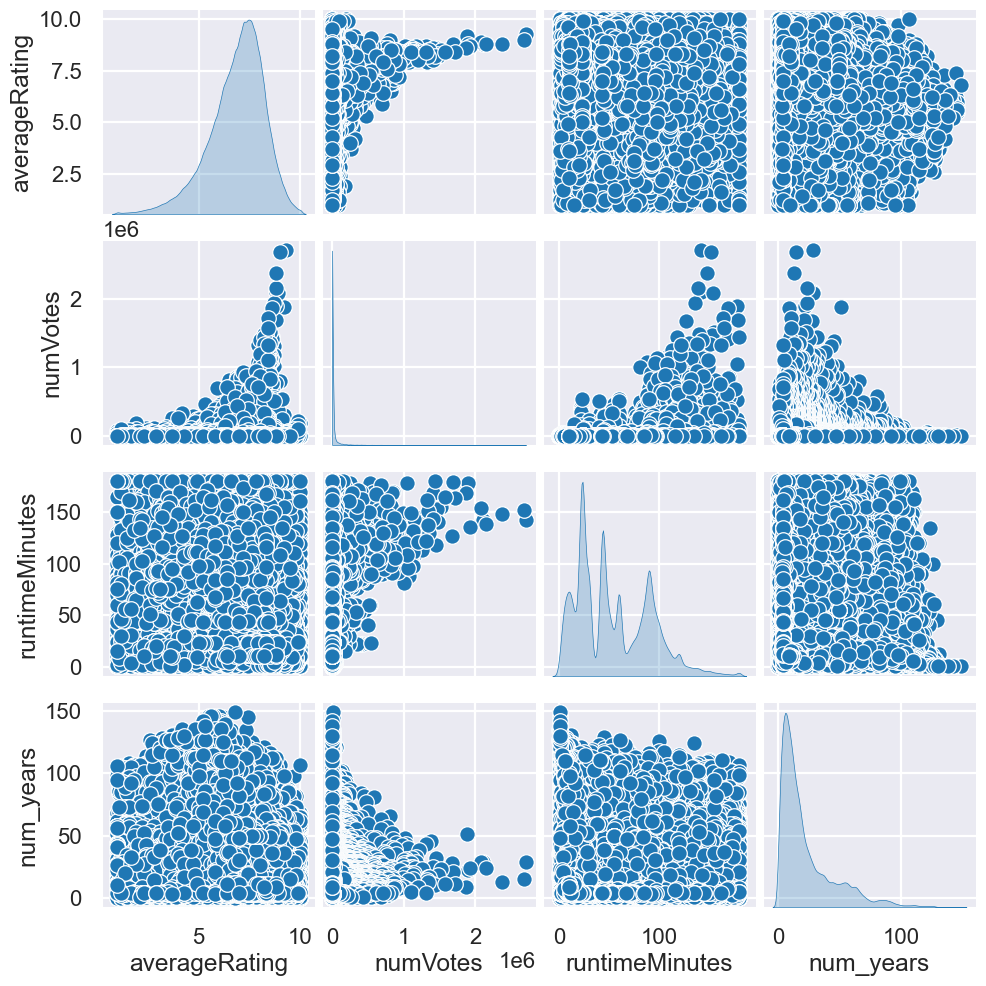

In [54]:
sns.pairplot(df_merge[['averageRating', 'numVotes', 'runtimeMinutes', 'num_years']], diag_kind='kde');

There is no obvious relationship shown from the above pair-plot. Some things to note:

1. `averageRating` stagnates as the `numVotes` increases - this might be due to the averaging of all the votes being cast and hence one 10 star rating (or 0 star rating) might not have a lot of effect.
2. `numVotes` decreases with the increase in `num_years` - people reviewing newer movies more as compared to old ones.
3. `numVotes` increases with the increasee in `runtimeMinutes` - people not reviewing movies that are too short

### <span style="color:maroon">Train-test split</span>
**Before doing any imputation on the numerical columns, we should split the dataset into training and testing set first**. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

In [55]:
numerical_features = ['numVotes', 'runtimeMinutes', 'num_years'] 
categorical_features = ['Musical', 'Fantasy', 'Short', 'Game-Show', 'History', 'Film-Noir',
        'Adult', 'Documentary', 'Crime', 'Reality-TV', 'Animation', 'Thriller',
        'Drama', 'Sport', 'War', 'Romance', 'Adventure', 'Action', 'Music',
        'Comedy', 'Biography', 'News', 'Horror', 'Sci-Fi', 'Western',
        'Talk-Show', 'Family', 'Mystery'] 
model_features = numerical_features + categorical_features
model_target = 'averageRating' 

We will use 85% of the dataset for training and 15% for testing. Given that the dataset is huge (~1M records), we should be good with this split. In addition, the random state is set to 66 to make sure we have repeatable results.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_merge[model_features], df_merge[model_target], test_size=0.15, random_state=66)

In [57]:
print(f'The shape of the training set is {X_train.shape}. ')
print(f'The shape of the test set is {X_test.shape}.')

The shape of the training set is (755009, 31). 
The shape of the test set is (133238, 31).


After the train-test split, now we can perform imputation for numerical columns.

Since `runtimeMinutes` might be an important factor in the IMDb ratings (movies that are not too long or not too short being rated higher), we will carry out an imputation task to make sure that there are no missing values in the training and test sets.

**Strategies for imputation**: <br>
It is important to get some statistics on the `runtimeMinutes` values to decide on whether to use mean/mode/median for the imputation. 

In [58]:
df_merge['runtimeMinutes'].describe()

count    888247.000000
mean         54.202930
std          36.369411
min           0.000000
25%          23.000000
50%          45.000000
75%          86.000000
max         180.000000
Name: runtimeMinutes, dtype: float64

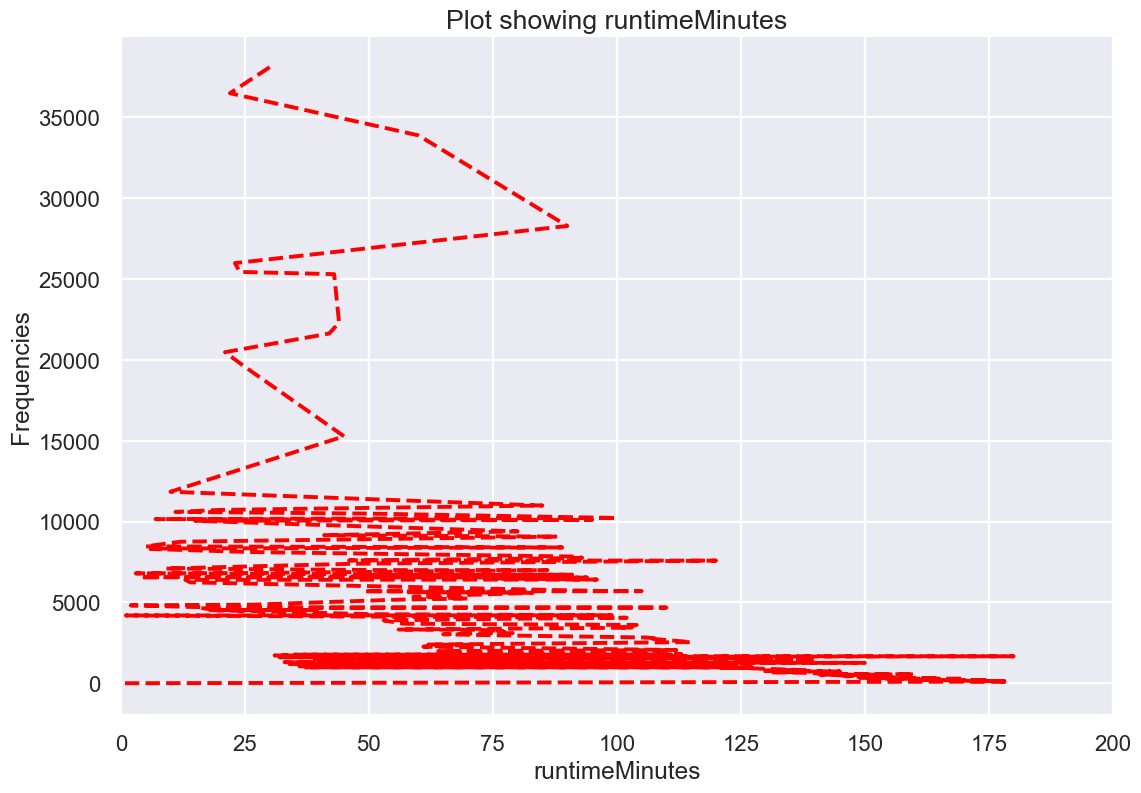

In [59]:
df_merge['runtimeMinutes'].value_counts().plot(linestyle='--', color='r')
plt.xlim([0, 200])
plt.xlabel('runtimeMinutes')
plt.ylabel('Frequencies')
plt.grid('ON')
plt.title('Plot showing runtimeMinutes');

In [60]:
df_merge['runtimeMinutes'].median()

45.0

### <span style='color:maroon'> Ideas for the imputation:</span>
1. From the above analysis, we can see that the minimum `runtimeMinutes` is 0 and the maximum is 180 with a mean of 54.18 minutes and standard deviation of 36.38 minutes.
2. We will use the `median` for imputation since median is more robust when it comes to outliers.

Therefore, we will use `median` of the `runtimeMinutes` for imputing the missing values which is `45.0 minutes`.

In [61]:
X_train['runtimeMinutes'].fillna((X_train['runtimeMinutes'].median()), inplace=True)

Similary, we perform the same idea to test set.

In [62]:
X_test['runtimeMinutes'].fillna((X_test['runtimeMinutes'].median()), inplace=True)

### <span style='color:maroon'> Ideas for the feature scaling:</span>
We will scale the numerical features for the training and test sets using `StandardScaler` feature offered by sklearn.

In [63]:
X_train[['numVotes', 'runtimeMinutes', 'num_years']] = StandardScaler().fit_transform(X_train[['numVotes', 'runtimeMinutes', 'num_years']])
X_test[['numVotes', 'runtimeMinutes', 'num_years']] = StandardScaler().fit_transform(X_test[['numVotes', 'runtimeMinutes', 'num_years']])

In [64]:
X_train.head()

,numVotes,runtimeMinutes,num_years,Musical,Fantasy,Short,Game-Show,History,Film-Noir,Adult,...,Music,Comedy,Biography,News,Horror,Sci-Fi,Western,Talk-Show,Family,Mystery
569898,-0.066921,-0.913104,-0.890996,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
290786,-0.030173,-0.830658,1.642964,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
254200,-0.053779,0.928171,0.375984,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188880,-0.067022,-1.352811,-0.936246,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
632391,-0.066921,-0.775695,1.371468,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [65]:
X_test.head()

,numVotes,runtimeMinutes,num_years,Musical,Fantasy,Short,Game-Show,History,Film-Noir,Adult,...,Music,Comedy,Biography,News,Horror,Sci-Fi,Western,Talk-Show,Family,Mystery
397706,-0.065254,-0.856845,-0.075479,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
200478,-0.040643,-1.408349,0.331152,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1204666,-0.063521,-0.470792,-0.798378,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
182802,-0.063215,0.714942,-0.075479,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1214598,-0.061534,-1.215323,-0.798378,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Now we have the preprocessed training and test sets to work with for our ML models.

## <span style="color:blue">Step 3: ML Models</span>

In this section, we will implement different ML models to compare their performance. 
The objective is to predict `averageRating` based on the other given features.

#### <span style="color:green">**Definitions of the evaluation metrics:** </span> 
* **Mean Absolute Error (MAE)**: the average of the absolute error values. The units of the error score match the units of the target value that is being predicted.
* **Mean Squared Error (MSE)**: average of the squared differences between predicted and expected target values in a dataset
* **Root Mean Squared Error (RMSE)**: square root of the MSE. The units of the RMSE are the same as the original units of the target value that is being predicted. 
* **R-squared (coefficient of determination)**: Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0. _**If the relationship between the independent and dependent variables is non-linear then we will have low R2 values despite the model being good.**_

### <span style="color:maroon">**Linear Regression**</span>: 
Linear regression is one of the simplest yet powerful model. In this method, a linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the _bias_ term. 

When training a model, we need to measure how well (or poorly) the model fits the training data. The most common performance measure of a regression model is the RMSE. Therefore, to train a linear regression model, we need to find the values of parameters that minimize the RMSE. 

In [66]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [67]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression()

In [68]:
# Apply the trained model on test set
y_pred_lr_test = linear_regressor.predict(X_test)

print('MAE on test set (LR):', mean_absolute_error(y_test, y_pred_lr_test))
print('MSE on test set (LR):', mean_squared_error(y_test, y_pred_lr_test))
print('RMSE on test set (LR):', np.sqrt(mean_squared_error(y_test, y_pred_lr_test)))
print('R2 score on test set (LR):', r2_score(y_test, y_pred_lr_test))

MAE on test set (LR): 0.9377366311528843
MSE on test set (LR): 1.5264531532412882
RMSE on test set (LR): 1.2354971279777578
R2 score on test set (LR): 0.15263155308353193


In [69]:
# Apply the trained model on training set to check if it overfits
y_pred_lr_train = linear_regressor.predict(X_train)

print('MAE on training set (LR):', mean_absolute_error(y_train, y_pred_lr_train))
print('MSE on training set (LR):', mean_squared_error(y_train, y_pred_lr_train))
print('RMSE on training set (LR):', np.sqrt(mean_squared_error(y_train, y_pred_lr_train)))
print('R2 score on training set (LR):', r2_score(y_train, y_pred_lr_train))

MAE on training set (LR): 0.9365979140260337
MSE on training set (LR): 1.5181437539836626
RMSE on training set (LR): 1.232129763451749
R2 score on training set (LR): 0.15669300246579143


From the above results, we can see that the metrics `Mean Absolute Error`, `Mean Squared Error`, `Root Mean Squared Error`, and `R-squared` by applying the trained Linear Regression model to the training and test sets are close to each other. This implies that the traind linear regression model does not over-fits the training set since the performance doesn't decline too much on the unseen test set. <br> 

Next, let's take a look at the values of parameters obtained from the trained Linear Regression model.

In [70]:
df_coeff_lr = pd.DataFrame(linear_regressor.coef_, X_test.columns, columns=['Coefficients'])
df_coeff_lr

,Coefficients
numVotes,0.055245
runtimeMinutes,-0.439205
num_years,-0.186810
Musical,-0.268323
Fantasy,0.131381
Short,-0.471091
Game-Show,0.366374
History,0.226970
Film-Noir,-0.271642
Adult,-0.033984


In [71]:
linear_regressor.intercept_

6.733186738795599

Now let's take a look at some of the actual ratings and predicted ratings.

In [72]:
df_comparison_lr = pd.DataFrame({'Actual Rating': y_test, 'Predicted Rating': y_pred_lr_test})
df_comparison_lr.sample(n=5)

,Actual Rating,Predicted Rating
1034293,6.7,7.122652
1191367,7.6,7.481319
1052449,4.0,6.965081
192947,7.1,6.552417
2523,6.6,6.423801


### <span style="color:maroon">**Random Forest Regressor**</span>: <br> 
Random Forests is an **ensemble learning method** for classification and regression. It **combines multiple decision trees to create a forest of trees**, hence the name "Random Forest". 
The basic idea behind random forests is to **train many decision trees independently and on different subsets of instances and features,** and then aggregate their predictions. <br> 

We will use `RandomizedSearchCV` in order to find the best hyperparameters to use for prediction purposes. 

In [73]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [77]:
param_grid = [
    {
        'max_depth': [3, 7],
        'min_samples_leaf': [1, 3],
        'n_estimators': [5, 10, 15, 20],
        'bootstrap': [True],
        'max_features': ['auto'],
        'min_samples_split': [3, 7],
        'oob_score': [True]
    }
]
random_search_rf = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                                      param_distributions=param_grid,
                                      cv=5, 
                                      verbose=0)
random_search_rf.fit(X_train, y_train)

print(f"The best parameters for our Random Forest Regressor are: {random_search_rf.best_params_}") 
print(f"The best cross-validation score:{random_search_rf.best_score_}") 

The best parameters for our Random Forest Regressor are: {'oob_score': True, 'n_estimators': 20, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 7, 'bootstrap': True}
The best cross-validation score:0.2622256850858452


In [78]:
# Build the model with the best parameters
random_forest = random_search_rf.best_estimator_

# Apply the trained model on test set
y_pred_rf = random_forest.predict(X_test)

print('MAE on test set (RF):', mean_absolute_error(y_test, y_pred_rf))
print('MSE on test set (RF):', mean_squared_error(y_test, y_pred_rf))
print('RMSE on test set (RF):', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R2 score on test set (RF):', r2_score(y_test, y_pred_rf))

MAE on test set (RF): 0.8639670840770283
MSE on test set (RF): 1.3494436564010424
RMSE on test set (RF): 1.1616555670253736
R2 score on test set (RF): 0.2508935024322487


### <span style="color:maroon">**Neural Network**</span>: <br> 

We have a big enough dataset to make use of more complex models like Neural Networks. These models are able to capture the inherent nonlinear relationship between the independent and dependent variable if there is any, as compared to simple linear regression models. 

In [80]:
# Import necessary libraries
from tensorflow import keras

In [87]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(15, activation = 'relu'), 
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam') # 'sgd'
history = model.fit(X_train, y_train, epochs=10)
mse_test_nn = model.evaluate(X_test, y_test)
y_pred_nn = model.predict(X_test)
r2_test_nn = r2_score(y_test, y_pred_nn)

Epoch 1/10
23595/23595 [==============================] - 30s 1ms/step - loss: 1.6099
Epoch 2/10
23595/23595 [==============================] - 27s 1ms/step - loss: 1.3069
Epoch 3/10
23595/23595 [==============================] - 24s 1ms/step - loss: 1.2967
Epoch 4/10
23595/23595 [==============================] - 29s 1ms/step - loss: 1.2906
Epoch 5/10
23595/23595 [==============================] - 26s 1ms/step - loss: 1.2852
Epoch 6/10
23595/23595 [==============================] - 24s 1ms/step - loss: 1.2824
Epoch 7/10
23595/23595 [==============================] - 28s 1ms/step - loss: 1.2776
Epoch 8/10
23595/23595 [==============================] - 26s 1ms/step - loss: 1.2743
Epoch 9/10
23595/23595 [==============================] - 27s 1ms/step - loss: 1.2720
Epoch 10/10
4164/4164 [==============================] - 3s 779us/step


In [88]:
print('MAE on test set (NN):', mean_absolute_error(y_test, y_pred_nn))
print('MSE on test set (NN):', mean_squared_error(y_test, y_pred_nn))
print('RMSE on test set (NN):', np.sqrt(mean_squared_error(y_test, y_pred_nn)))
print('R2 score on test set (NN):', r2_score(y_test, y_pred_nn))

MAE on test set (NN): 0.8378976474193873
MSE on test set (NN): 1.2743071059431763
RMSE on test set (NN): 1.1288521187220124
R2 score on test set (NN): 0.2926034900155223


### <span style="color:blue">**Step 4: Results and conclusion** </span>

In this section, we will compare the 3 models we trained from the previous section.

In [89]:
print('************Linear Regression results***************')
print('MAE on test set (LR):', mean_absolute_error(y_test, y_pred_lr_test))
print('MSE on test set (LR):', mean_squared_error(y_test, y_pred_lr_test))
print('RMSE on test set (LR):', np.sqrt(mean_squared_error(y_test, y_pred_lr_test)))
print('R2 score on test set (LR):', r2_score(y_test, y_pred_lr_test))
print('\n')
print('************Random Forest results***************')
print('MAE on test set (RF):', mean_absolute_error(y_test, y_pred_rf))
print('MSE on test set (RF):', mean_squared_error(y_test, y_pred_rf))
print('RMSE on test set (RF):', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R2 score on test set (RF):', r2_score(y_test, y_pred_rf))
print('\n')
print('************Neural Network results***************')
print('MAE on test set (NN):', mean_absolute_error(y_test, y_pred_nn))
print('MSE on test set (NN):', mean_squared_error(y_test, y_pred_nn))
print('RMSE on test set (NN):', np.sqrt(mean_squared_error(y_test, y_pred_nn)))
print('R2 score on test set (NN):', r2_score(y_test, y_pred_nn))

************Linear Regression results***************
MAE on test set (LR): 0.9377366311528843
MSE on test set (LR): 1.5264531532412882
RMSE on test set (LR): 1.2354971279777578
R2 score on test set (LR): 0.15263155308353193


************Random Forest results***************
MAE on test set (RF): 0.8639670840770283
MSE on test set (RF): 1.3494436564010424
RMSE on test set (RF): 1.1616555670253736
R2 score on test set (RF): 0.2508935024322487


************Neural Network results***************
MAE on test set (NN): 0.8378976474193873
MSE on test set (NN): 1.2743071059431763
RMSE on test set (NN): 1.1288521187220124
R2 score on test set (NN): 0.2926034900155223


#### <span style="color:green">**Observations:** </span> 
1. Among all the models considered, Neural networks perform the best followed by random forest models, and then simple regression models. However, in case of simple regression, the training time was substantially less as compared to the other models. 
2. For all the three models, the R2 value remains very low. This might be due to the fact that the relationship between the independent and dependent variables might not be linear. 
3. The random forest and neural network models were trained for limited hyperparameters and epochs due to lack of resources. Training them for longer will definitely improve the results. 

### <span style="color:blue">**Step 5: Future Work** </span>
1. Include selected data from the 4 datasets that were excluded for this analysis. The names of the actors, directors, writers, etc. do have an effect on the IMDb ratings of a movie. 
2. Include information regarding the `region`, `language`, and `types` of distribution for the movies. Movies belonging to certain languages/regions might be getting higher ratings as compared to others due to the differences in the number of audiences. Similary, the delivery method for a movie might also have effects on the ratings. 
3. Try out more combinations of hyperparameters for the Random Forest model which would take longer and more computational resources. 
4. Try out a deeper/complex neural network structures to see how things turn out. 